# Explorative Datenanalyse der Kriminalität in Chicago
----

# Konfiguration

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import geopandas
from shapely.geometry import Point
import folium
import folium.plugins


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [4]:
# Chrome / Folium incompatibility workaround
def embed_map(m):
    from IPython.display import IFrame

    m.save('geo/folium_index.html')
    return IFrame('geo/folium_index.html', width='100%', height='750px')

#### Load Data

In [5]:
%%time

# Load Crime data into DataFrame and parse Datetime
dateparse = lambda x: pd.datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p')

crimes = pd.read_csv(f"data/crimes.csv", parse_dates=['Date', 'Updated On'], date_parser=dateparse)


# Initialize GeoDataFrame from crime DF and load chicago map geometry
crimes['_Coordinates'] = list(zip(crimes.Longitude, crimes.Latitude))
crimes['_Coordinates'] = crimes['_Coordinates'].apply(Point)
crimes = geopandas.GeoDataFrame(crimes, geometry='_Coordinates')

beats_map = geopandas.read_file('geo/Boundaries - Police Beats (current).geojson')

CPU times: user 4min, sys: 6.53 s, total: 4min 6s
Wall time: 4min 8s


# Cleaning

In [6]:
# Domestic Violence hat nur einen einzigen Eintrag
crimes = crimes[crimes['Primary Type'] != 'DOMESTIC VIOLENCE'] 

# District 31 besteht aus den unabhängigen Städten Norridge und Harwood Heights, die nicht zur Polizeiverwaltung der Stadt Chicago gehören.
beats_map = beats_map[beats_map.district != '31'] 

In [7]:
crimes.head(2)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,_Coordinates
0,10000092,HY189866,2015-03-18 19:44:00,047XX W OHIO ST,041A,BATTERY,AGGRAVATED: HANDGUN,STREET,False,False,1111,11.0,28.0,25.0,04B,1144606.0,1903566.0,2015,2018-02-10 15:50:01,41.891399,-87.744385,"(41.891398861, -87.744384567)",POINT (-87.74438456700001 41.891398861)
1,10000094,HY190059,2015-03-18 23:00:00,066XX S MARSHFIELD AVE,4625,OTHER OFFENSE,PAROLE VIOLATION,STREET,True,False,725,7.0,15.0,67.0,26,1166468.0,1860715.0,2015,2018-02-10 15:50:01,41.773372,-87.665319,"(41.773371528, -87.665319468)",POINT (-87.66531946799999 41.773371528)


In [155]:
crimes.groupby(crimes['Primary Type']).size().sort_values(ascending=False)

Primary Type
THEFT                                1417696
BATTERY                              1232015
CRIMINAL DAMAGE                       771356
NARCOTICS                             710760
OTHER OFFENSE                         418441
ASSAULT                               418375
BURGLARY                              387936
MOTOR VEHICLE THEFT                   314156
DECEPTIVE PRACTICE                    262300
ROBBERY                               255578
CRIMINAL TRESPASS                     193342
WEAPONS VIOLATION                      70639
PROSTITUTION                           68322
PUBLIC PEACE VIOLATION                 47775
OFFENSE INVOLVING CHILDREN             45301
CRIM SEXUAL ASSAULT                    27075
SEX OFFENSE                            25081
INTERFERENCE WITH PUBLIC OFFICER       15136
GAMBLING                               14422
LIQUOR LAW VIOLATION                   14061
ARSON                                  11151
HOMICIDE                                94

# Häufigkeit pro Straftatenart

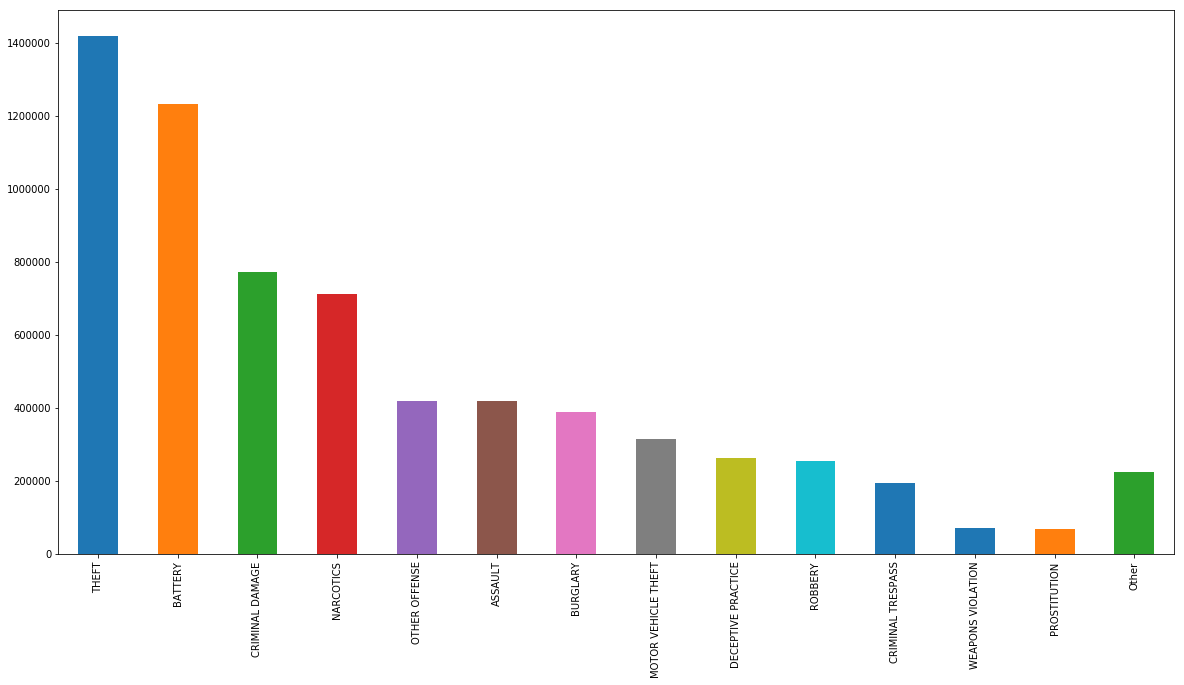

In [153]:
c = crimes
c = c.groupby(crimes['Primary Type']).size().sort_values(ascending=False)
other = pd.Series(c[13:].sum())
other.index = other.index[:-1].append(pd.Index(['Other']))

c = c[0:13].append(other)

c.plot(figsize=(20,10), kind='bar')



# Verhaftungsraten

> Enden gewaltsame Straftaten überproportional oft in Verhaftungen?

In [45]:
c = crimes
c = c.groupby(['Primary Type', 'Arrest']).size().sort_values(ascending=False)
c = c.unstack()
c['Total'] = c[False] + c[True]
c = c.sort_values(ascending=False, by='Total')
c['Fraction'] = (c[True] / (c[True] + c[False]))
arrest_percent = c.sort_values(ascending=False, by='Total')

### Hohe Verhaftungsrate

,Description,Probability of Arrest
0,PROSTITUTION,99.60%
1,NARCOTICS,99.41%
2,PUBLIC INDECENCY,99.38%
3,GAMBLING,99.28%
4,LIQUOR LAW VIOLATION,99.10%
5,CONCEALED CARRY LICENSE VIOLATION,93.29%
6,INTERFERENCE WITH PUBLIC OFFICER,91.72%
7,OBSCENITY,82.76%
8,WEAPONS VIOLATION,79.58%
9,CRIMINAL TRESPASS,73.25%


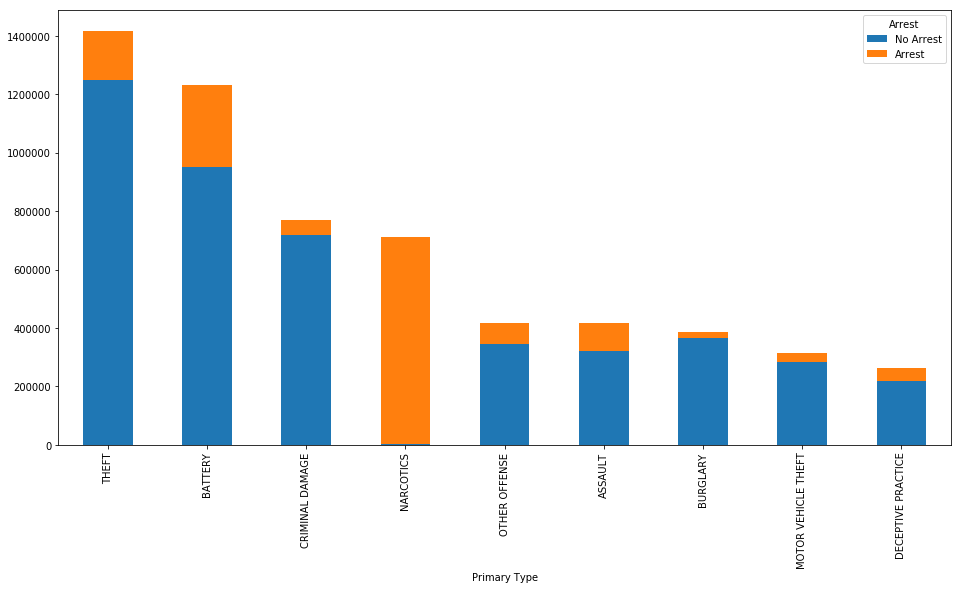

In [51]:
x = arrest_percent
x = x.rename(index=str, columns={False: "No Arrest", True: 'Arrest'})
x = x.sort_values(by='Total', ascending=False)
x = x[['No Arrest', 'Arrest']]
x = x.head(9)

#x.T.plot(kind='pie', subplots=True, figsize=(30, 20), layout=(3, 3))
x.plot(kind='bar', stacked=True, figsize=(16, 8))

x = arrest_percent.Fraction.astype(float).sort_values(ascending=False).map("{:.2%}".format).head(12)
pd.DataFrame({'Description':x.index, 'Probability of Arrest':x.values})

### Niedrige Verhaftungsrate

In [54]:
x = arrest_percent.Fraction.astype(float).sort_values(ascending=False).map("{:.2%}".format).tail(12)
pd.DataFrame({'Description':x.index, 'Probability of Arrest':x.values})

,Description,Probability of Arrest
0,NON - CRIMINAL,15.79%
1,CRIM SEXUAL ASSAULT,15.66%
2,RITUALISM,13.04%
3,ARSON,13.02%
4,HUMAN TRAFFICKING,12.24%
5,THEFT,11.95%
6,KIDNAPPING,11.12%
7,ROBBERY,9.70%
8,MOTOR VEHICLE THEFT,9.13%
9,CRIMINAL DAMAGE,7.06%


### Verhaftungsraten: Diebstahl

In [55]:
c = crimes
c = c[c['Primary Type'] == 'THEFT']
c = c.set_index('Description').sort_index()
c = c.groupby(['Description', 'Arrest']).size().sort_values(ascending=False).unstack()
c['Total'] = c[False] + c[True]
c = c.sort_values(ascending=False, by='Total')
c.drop('Total', axis=1)
c = (c[True] / (c[True] + c[False]))
c = c.sort_values(ascending=False)

c = c.astype(float).map("{:.2%}".format).rename('wfj')

df = pd.DataFrame({'Description':c.index, 'Probability of Arrest':c.values})

In [13]:
df

,Description,Probability of Arrest
0,RETAIL THEFT,60.43%
1,ATTEMPT THEFT,24.89%
2,DELIVERY CONTAINER THEFT,22.10%
3,FROM COIN-OP MACHINE/DEVICE,16.54%
4,$500 AND UNDER,7.95%
5,OVER $500,3.87%
6,AGG: FINANCIAL ID THEFT,3.17%
7,FROM BUILDING,2.66%
8,PURSE-SNATCHING,2.58%
9,POCKET-PICKING,2.02%


In [14]:
df[(df.Description == ('$500 AND UNDER')) | (df.Description == ('OVER $500'))]

,Description,Probability of Arrest
4,$500 AND UNDER,7.95%
5,OVER $500,3.87%


Mögliche Eklärungen: 
- Wertvollere Gegenstände sind eher/besser versichert
- Diebstahl wertvoller Gegenstände ist besser geplant / Affekthandlung bei günstigen Gegenständen

### Verhaftungsraten: Drogen

In [15]:
c = crimes
c = c[c['Primary Type'] == 'NARCOTICS']
c = c.set_index('Description').sort_index()
c = c.groupby(['Description', 'Arrest']).size().sort_values(ascending=False).unstack()
c['Total'] = c[False] + c[True]
c = c.sort_values(ascending=False, by='Total')
c.drop('Total', axis=1)
c = (c[True] / (c[True] + c[False]))
c = c.sort_values(ascending=False)

c = c.astype(float).dropna()
p = c.map("{:.2%}".format)

df = pd.DataFrame({'Description':p.index, 'Probability of Arrest':p.values})
df.head(5).append(df.tail(5))

,Description,Probability of Arrest
0,POSS: PCP,99.80%
1,ATTEMPT POSSESSION NARCOTICS,99.71%
2,SOLICIT NARCOTICS ON PUBLICWAY,99.60%
3,POSS: BARBITUATES,99.60%
4,POS: HYPODERMIC NEEDLE,99.56%
37,MANU/DELIVER: HALLUCINOGEN,97.84%
38,DELIVER CANNABIS TO PERSON <18,97.78%
39,CRIMINAL DRUG CONSPIRACY,96.90%
40,CALCULATED CANNABIS CONSPIRACY,83.33%
41,FAIL REGISTER LIC:CONT SUBS,80.00%


In [16]:
print(f'Standard Abweichung der Verhaftungsrate von verschiedenen Drogendeliktarten:\n{"%.3f" % c.std()}')

Standard Abweichung der Verhaftungsrate von verschiedenen Drogendeliktarten:
0.038


Die Art des Drogendeliktes hat anscheinend keinen Einfluss auf die Verhaftungsrate. 

# Zeit & Datum

In [17]:
crimes.head(1)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,_Coordinates
0,10000092,HY189866,2015-03-18 19:44:00,047XX W OHIO ST,041A,BATTERY,AGGRAVATED: HANDGUN,STREET,False,False,1111,11.0,28.0,25.0,04B,1144606.0,1903566.0,2015,2018-02-10 15:50:01,41.891399,-87.744385,"(41.891398861, -87.744384567)",POINT (-87.74438456700001 41.891398861)


#### Tag

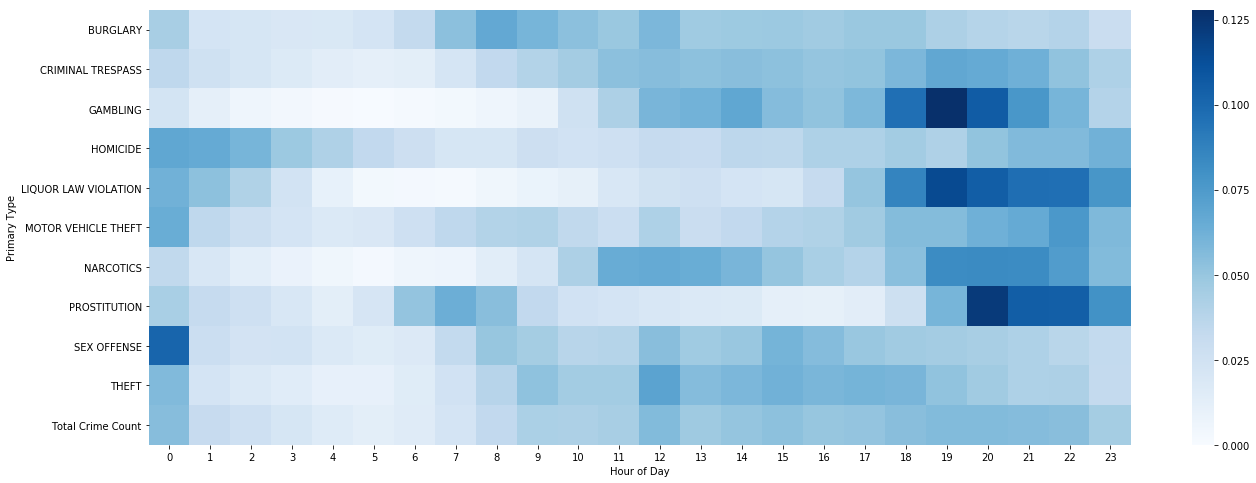

In [18]:
c = crimes

types = ['NARCOTICS', 'PROSTITUTION', 'THEFT', 'MOTOR VEHICLE THEFT', 'BURGLARY', 'CRIMINAL TRESPASS', 'GAMBLING', 'LIQUOR LAW VIOLATION', 'HOMICIDE', 'SEX OFFENSE']
types.sort()

types += ['Total Crime Count']

c = c.groupby([c.Date.dt.hour, c['Primary Type']]).size()
c = c.unstack()
c = c.rename_axis('Hour of Day')
c['Total Crime Count'] = c.sum(axis=1)

c = c[types]
c = c.T

c = (c.T / c.T.sum()).T

plt.subplots(figsize=(22,8))
s = sns.heatmap(c, annot=False, cmap="Blues", cbar=True, vmin=0)

#### Woche

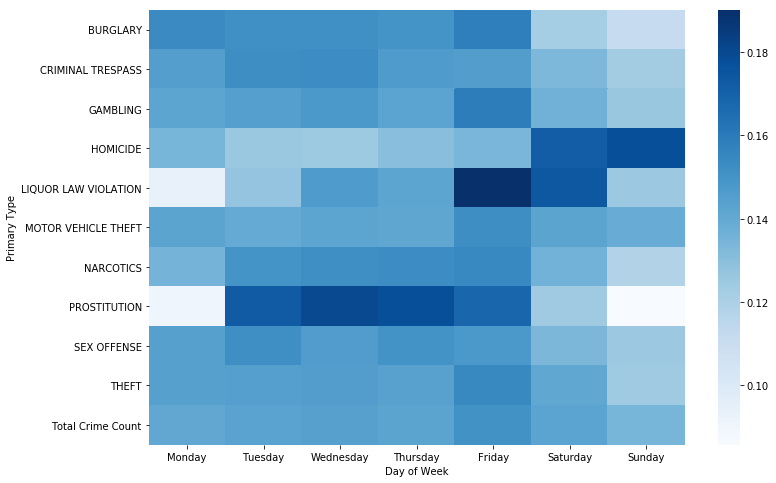

In [19]:
c = crimes

types = ['NARCOTICS', 'PROSTITUTION', 'THEFT', 'MOTOR VEHICLE THEFT', 'BURGLARY', 'CRIMINAL TRESPASS', 'GAMBLING', 'LIQUOR LAW VIOLATION', 'HOMICIDE', 'SEX OFFENSE']
types.sort()

types += ['Total Crime Count']

c = c.groupby([c.Date.dt.day_name(), c['Primary Type']]).size()
c = c.unstack()
c = c.rename_axis('Day of Week')
c['Total Crime Count'] = c.sum(axis=1)
c = c[types]

c.index = pd.CategoricalIndex(c.index, categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
c = c.sort_index()

c = c.T
c = (c.T / c.T.sum()).T

plt.subplots(figsize=(12,8))
s = sns.heatmap(c, annot=False, cmap="Blues", cbar=True)

#### Jahr

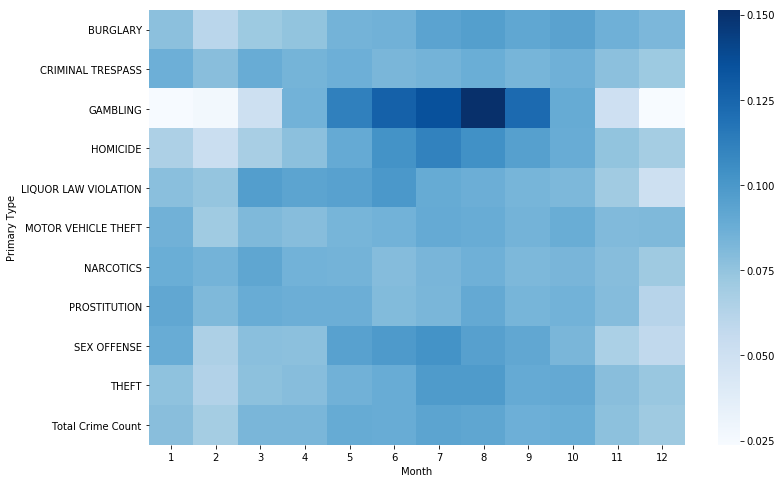

In [20]:
c = crimes

types = ['NARCOTICS', 'PROSTITUTION', 'THEFT', 'MOTOR VEHICLE THEFT', 'BURGLARY', 'CRIMINAL TRESPASS', 'GAMBLING', 'LIQUOR LAW VIOLATION', 'HOMICIDE', 'SEX OFFENSE']
types.sort()

types += ['Total Crime Count']

c = c.groupby([c.Date.dt.month, c['Primary Type']]).size()
c = c.unstack()
c = c.rename_axis('Month')
c['Total Crime Count'] = c.sum(axis=1)
c = c[types]

c = c.T
c = (c.T / c.T.sum()).T

plt.subplots(figsize=(12,8))
s = sns.heatmap(c, annot=False, cmap="Blues", cbar=True)

#### Glücksspiel

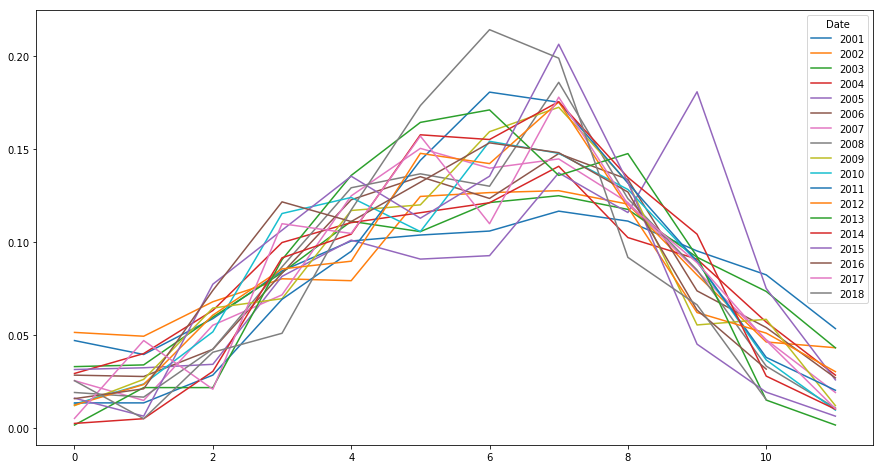

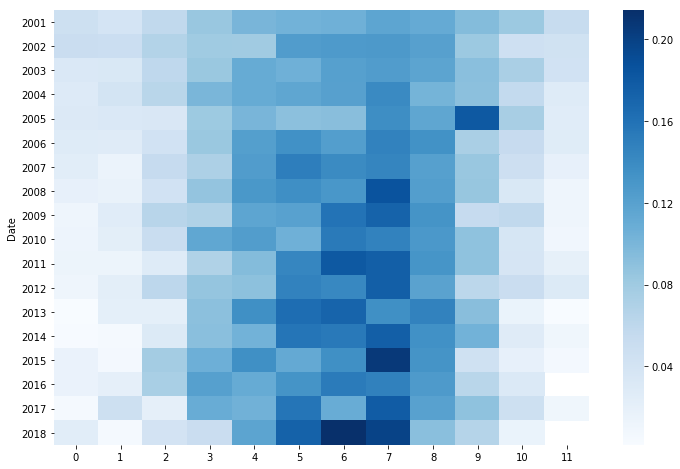

In [21]:
c = crimes
c = c[c['Primary Type'] == 'GAMBLING']

#types += ['Total Crime Count']

c = c.groupby([c.Date.dt.year, c.Date.dt.month]).size()

c = c.unstack(0)
c = c.reset_index(drop=True)
c = c
c = (c / c.sum())
c = c


c.plot(figsize=[15,8])
plt.subplots(figsize=(12,8))
s = sns.heatmap(c.T, annot=False, cmap="Blues", cbar=True)

#### 2001 bis 20018

In [ ]:
c = crimes

types = ['NARCOTICS', 'PROSTITUTION', 'THEFT', 'MOTOR VEHICLE THEFT', 'BURGLARY', 'CRIMINAL TRESPASS', 'GAMBLING', 'LIQUOR LAW VIOLATION', 'HOMICIDE', 'SEX OFFENSE']
types.sort()

types += ['Total Crime Count']

c = c.groupby([c.Date.dt.year, c['Primary Type']]).size()
c = c.unstack()
c = c.rename_axis('Year')
c['Total Crime Count'] = c.sum(axis=1)
c = c[types]

c = c.T
c = (c.T / c.T.sum()).T

plt.subplots(figsize=(19,8))
s = sns.heatmap(c, annot=False, cmap="Blues", cbar=True)
c.T.plot(figsize=(19,8))

c.loc[c == 'Total Crime Count']


# Räumlich-geografische Analyse

#### Kriminalität pro "Beat" (Alle Straftattypen)

/Users/sbokai/miniconda3/envs/chicago-crime/lib/python3.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


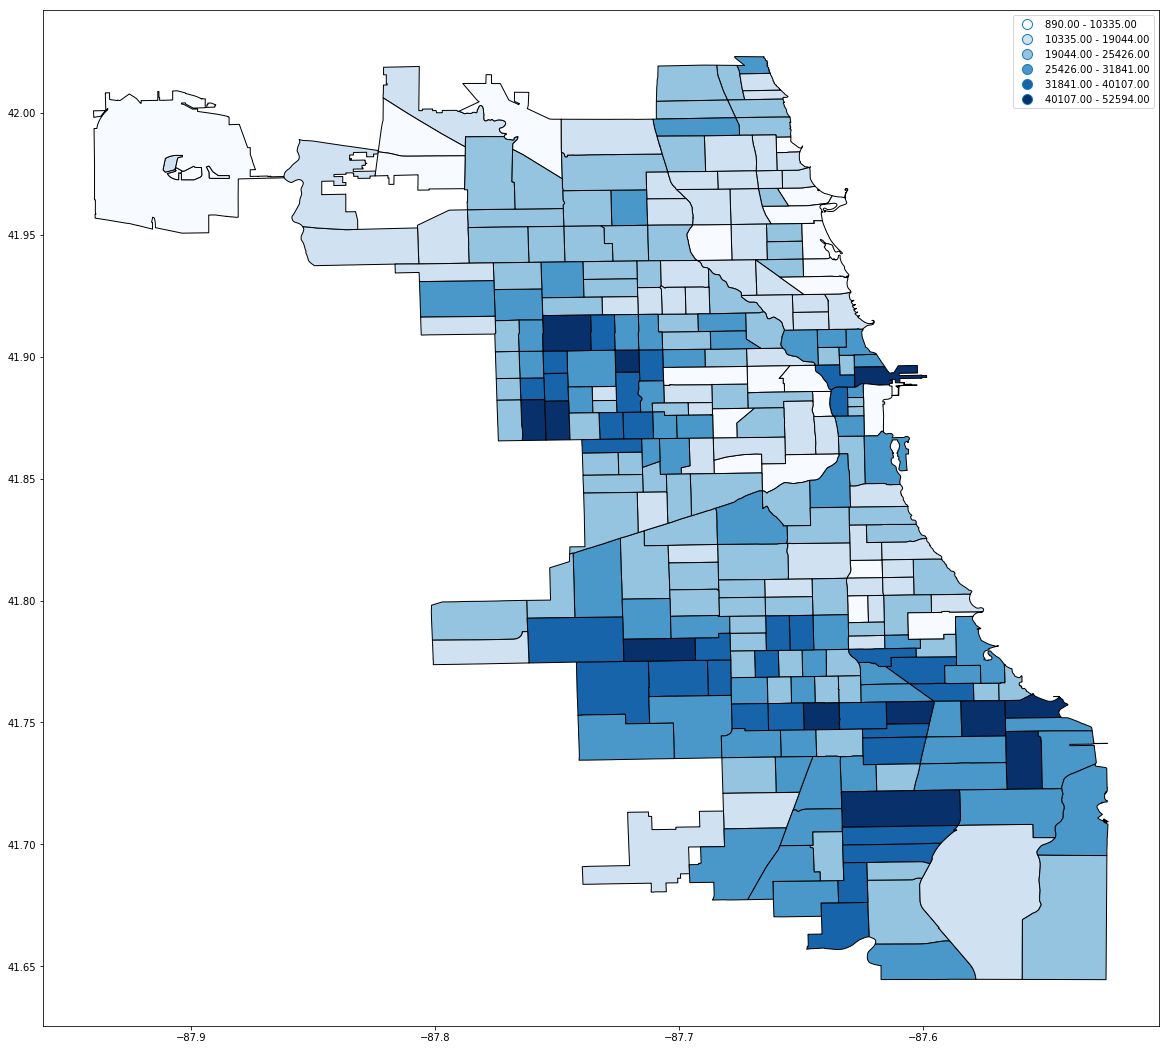

In [23]:
c = crimes

#c = c[c['Primary Type'] == 'THEFT']


c = c.groupby('Beat').size().rename_axis('beat_num').rename('crimes_per_beat')

c.index = c.index.astype(str)
c.index = c.index.str.zfill(4)

c = beats_map[['beat_num', 'geometry']].join(c, on='beat_num')

c.crimes_per_beat = c.crimes_per_beat.fillna(0)

c.plot(column='crimes_per_beat', scheme='Fisher_Jenks', cmap='Blues', figsize=(20,20), edgecolor='k', legend=True, k=6)

#### Interaktive Karte (Alle Straftattypen)

In [59]:
m = folium.Map([41.833648, -87.634467], zoom_start=10)

c = crimes

#c = c[c['Primary Type'] == 'NARCOTICS']

c = c.sample(30000)
c = c.fillna(0)

if (len(c) > 150000):
    print(f'Too many points to render. ({len(c)})')
    raise

#_Coordinates.map(lambda x: if (x.isna)[x.x, x.y]).tolist()


c_coords = list(zip(c.Latitude, c.Longitude))

folium.plugins.HeatMap(c_coords, name='Heatmap', blur=35, show=True).add_to(m)
folium.plugins.MarkerCluster(c_coords, name='Cluster', show=False).add_to(m)
folium.GeoJson(beats_map, name='Police Beats', show=False).add_to(m)

c = c.groupby('Beat').size().rename_axis('beat_num').rename('crimes_per_beat')

c.index = c.index.astype(str)
c.index = c.index.str.zfill(4)

c = beats_map[['beat_num', 'geometry']].join(c, on='beat_num')

c.crimes_per_beat = c.crimes_per_beat.fillna(0)

folium.Choropleth(
    geo_data=c, 
    data=c,
    columns=('beat_num', 'crimes_per_beat'), 
    key_on='feature.properties.beat_num', 
    fill_color='OrRd',
    nan_fill_color='black',
    legend_name='Registered Crimes (2001 - 2018)',
    name='Choropleth',
    show=False
).add_to(m)

folium.LayerControl().add_to(m) 
embed_map(m)

# Sonstiges (PLACEHOLDER)

#### Korrelationsmatrix (Auswahl)

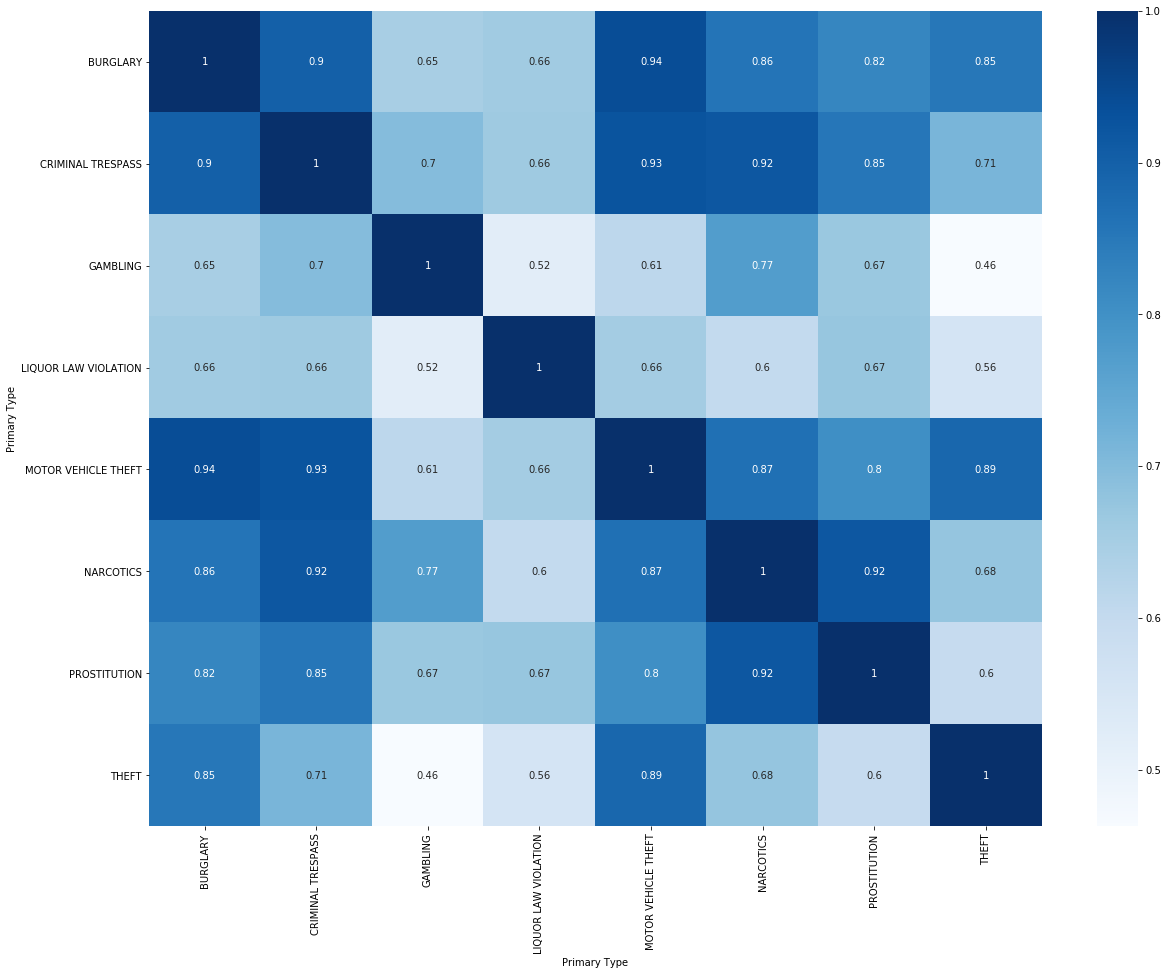

In [219]:
c = crimes

types = ['NARCOTICS', 'PROSTITUTION', 'THEFT', 'MOTOR VEHICLE THEFT', 'BURGLARY', 'CRIMINAL TRESPASS', 'GAMBLING', 'LIQUOR LAW VIOLATION']
types.sort()

#types += ['Total Crime Count']
#types += ['NON-CRIMINAL'] # Validierung. Muss nahe 0 sein, da z.B. "Passport verloren" keinen logischen Zusammenhang mit "Mord" hat.

c = c.groupby([c.Date.dt.day, c['Primary Type']]).size()
c = c.unstack()
c['Total Crime Count'] = c.sum(axis=1)

c = c[types]
change = c.pct_change()

corr = change.corr()

plt.subplots(figsize=(20,15))
s = sns.heatmap(corr, annot=True, cmap="Blues")
s = s.set_yticklabels(s.get_yticklabels(), rotation = 0)

#### Korrelation mit allg. Kriminalität

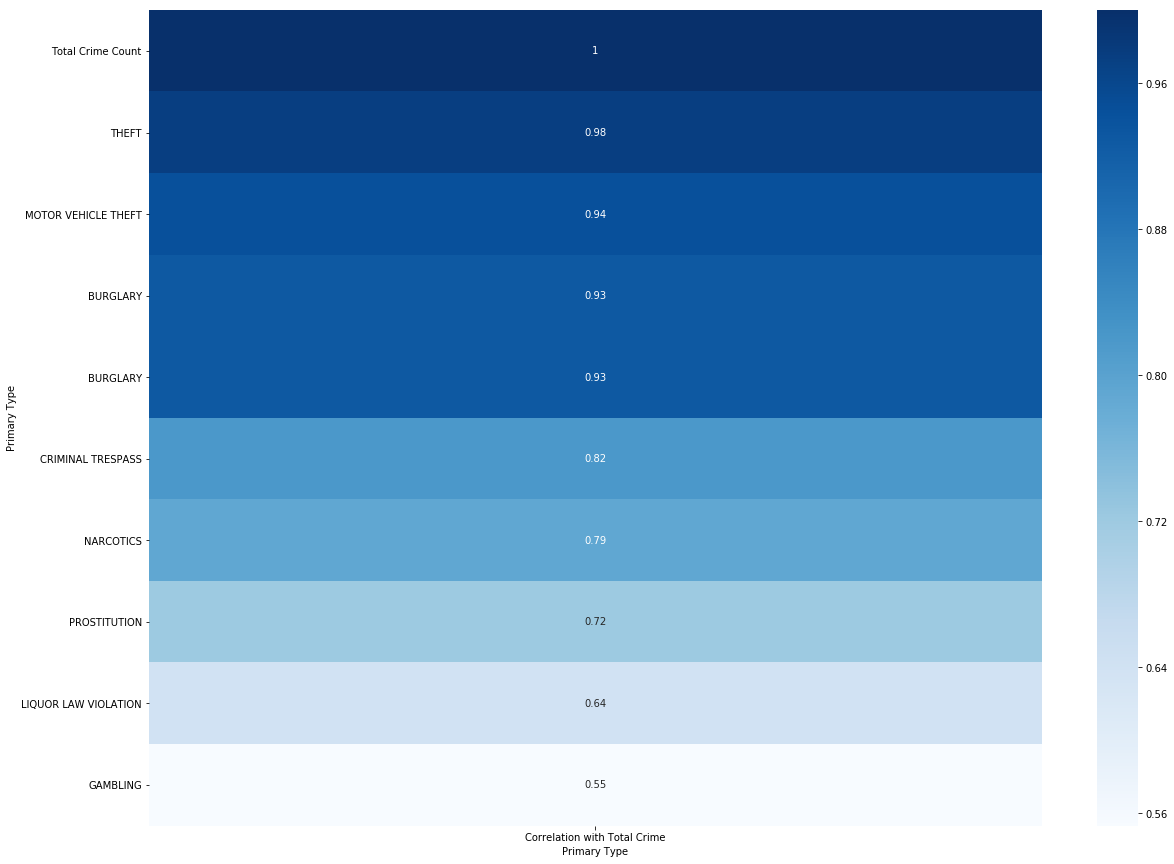

In [206]:
c = crimes

types = ['NARCOTICS', 'PROSTITUTION', 'THEFT', 'MOTOR VEHICLE THEFT', 'BURGLARY', 'CRIMINAL TRESPASS', 'GAMBLING', 'LIQUOR LAW VIOLATION', 'BURGLARY',]
types.sort()

types += ['Total Crime Count']
#types += ['NON-CRIMINAL'] # Validierung. Muss nahe 0 sein, da z.B. "Passport verloren" keinen logischen Zusammenhang mit "Mord" hat.

c = c.groupby([c.Date.dt.day, c['Primary Type']]).size()
c = c.unstack()
c['Total Crime Count'] = c.sum(axis=1)

c = c[types]
change = c.pct_change()

corr = change.corr()

corr = corr.loc[:, ['Total Crime Count']]
corr = corr.sort_values(by='Total Crime Count', ascending=False)

corr = corr.rename(index=str, columns={'Total Crime Count': 'Correlation with Total Crime'})

plt.subplots(figsize=(20,15))
s = sns.heatmap(corr, annot=True, cmap="Blues")
s = s.set_yticklabels(s.get_yticklabels(), rotation = 0)

#### Korrelation Diebstahl Detail

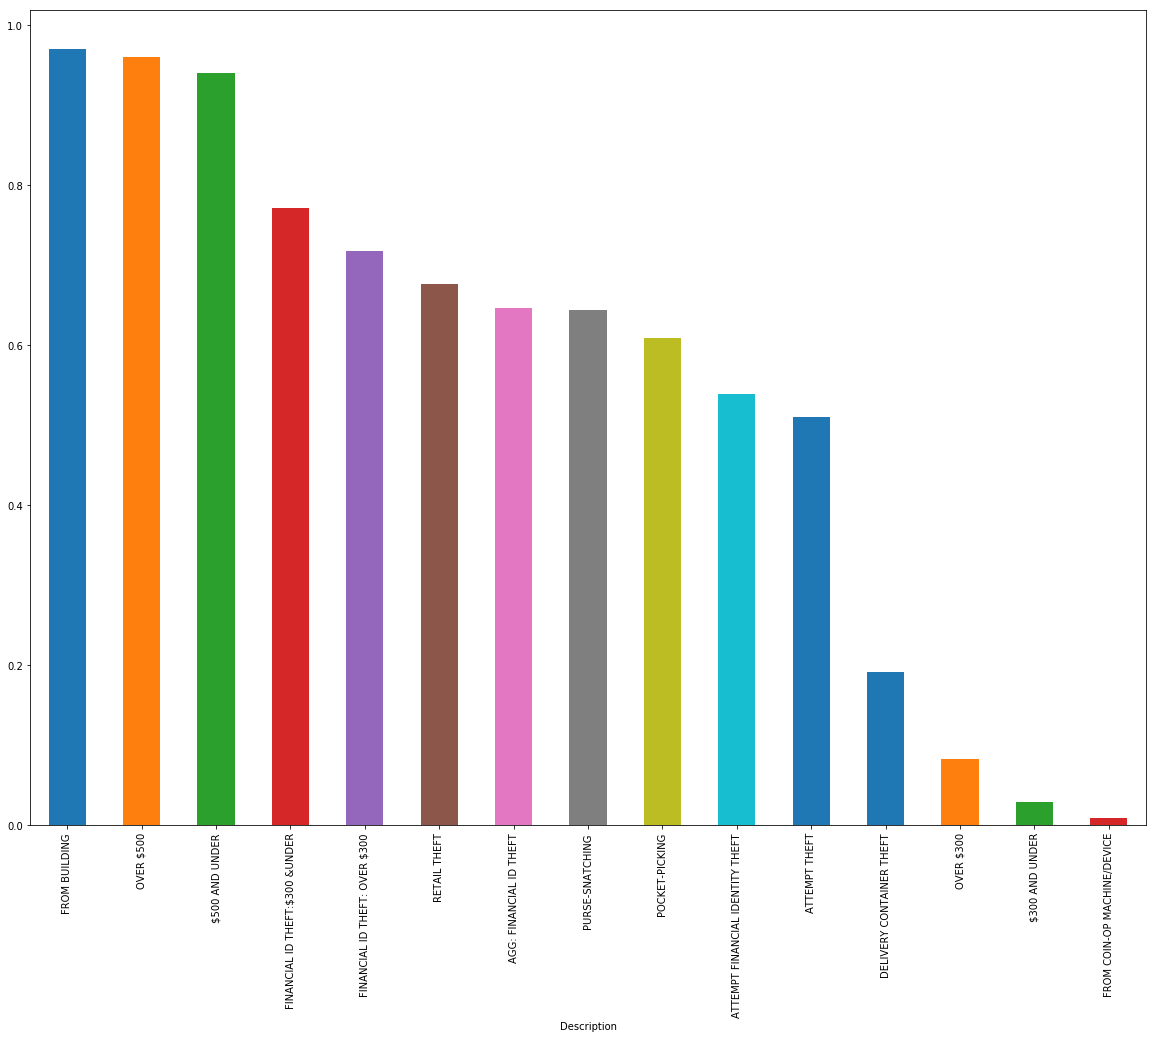

In [216]:
c = crimes

c = c[c['Primary Type'] == 'THEFT']

c = c.groupby([c.Date.dt.day, c['Description']]).size()
c = c.unstack()
c['Total Crime Count'] = c.sum(axis=1)

change = c.pct_change()

corr = change.corr()

corr = corr.loc[:, ['Total Crime Count']]
corr = corr.sort_values(by='Total Crime Count', ascending=False)
corr = corr.dropna()

corr = corr.loc[corr.index != 'Total Crime Count']

corr = corr.rename(index=str, columns={'Total Crime Count': 'Correlation with Total Crime'})


corr['Correlation with Total Crime'].plot(kind='bar', figsize=(20,15), legend=False)

#### Korrelation Tötungsdelikte Detail

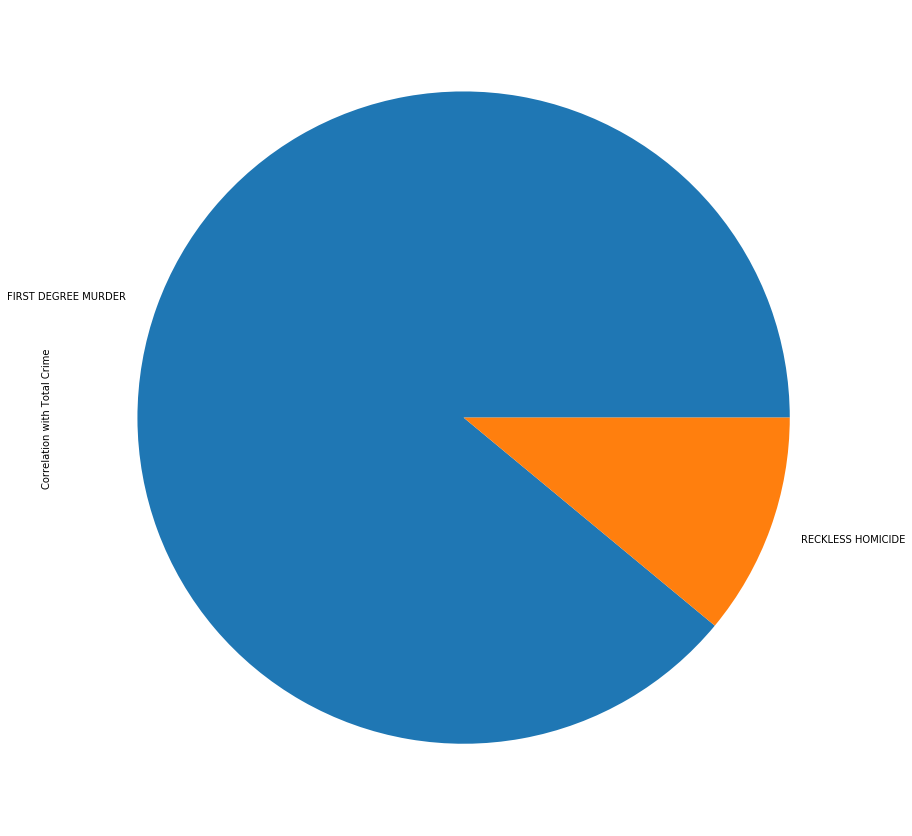

In [217]:
c = crimes

c = c[c['Primary Type'] == 'HOMICIDE']

c = c.groupby([c.Date.dt.day, c['Description']]).size()
c = c.unstack()
c['Total Crime Count'] = c.sum(axis=1)

#c = c[types]
change = c.pct_change()

corr = change.corr()

corr = corr.loc[:, ['Total Crime Count']]
corr = corr.sort_values(by='Total Crime Count', ascending=False)

corr = corr.loc[corr.index != 'Total Crime Count']

corr = corr.rename(index=str, columns={'Total Crime Count': 'Correlation with Total Crime'})


#plt.subplots(figsize=(20,15))
#s = sns.heatmap(corr, annot=True, cmap="Blues")
#s = s.set_yticklabels(s.get_yticklabels(), rotation = 0)

corr = corr.dropna()
corr['Correlation with Total Crime'].plot(kind='pie', figsize=(20,15), legend=False)

